In [2]:
!pip install fastf1
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.13.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


In [13]:
import fastf1
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev

In [5]:
schedule = fastf1.get_event_schedule(2024)
print(schedule[['EventName', 'EventDate']])

req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) /root/.cache/fastf1


                    EventName  EventDate
0          Pre-Season Testing 2024-02-23
1          Bahrain Grand Prix 2024-03-02
2    Saudi Arabian Grand Prix 2024-03-09
3       Australian Grand Prix 2024-03-24
4         Japanese Grand Prix 2024-04-07
5          Chinese Grand Prix 2024-04-21
6            Miami Grand Prix 2024-05-05
7   Emilia Romagna Grand Prix 2024-05-19
8           Monaco Grand Prix 2024-05-26
9         Canadian Grand Prix 2024-06-09
10         Spanish Grand Prix 2024-06-23
11        Austrian Grand Prix 2024-06-30
12         British Grand Prix 2024-07-07
13       Hungarian Grand Prix 2024-07-21
14         Belgian Grand Prix 2024-07-28
15           Dutch Grand Prix 2024-08-25
16         Italian Grand Prix 2024-09-01
17      Azerbaijan Grand Prix 2024-09-15
18       Singapore Grand Prix 2024-09-22
19   United States Grand Prix 2024-10-20
20     Mexico City Grand Prix 2024-10-27
21       São Paulo Grand Prix 2024-11-03
22       Las Vegas Grand Prix 2024-11-23
23           Qat

In [6]:
YEAR = 2024
GRAND_PRIX = 'British Grand Prix'
SESSION_TYPE = 'R'
TARGET_DRIVER_INDEX = 0  # 0 = Winner, 1 = 2nd place etc.

In [7]:
session = fastf1.get_session(YEAR, GRAND_PRIX, SESSION_TYPE)
session.load()

core           INFO 	Loading data for British Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

In [8]:
results = session.results
laps = session.laps
top_drivers = results.head(10)['Abbreviation'].tolist()
target_driver = top_drivers[TARGET_DRIVER_INDEX]

In [9]:
# --- GET TELEMETRY ---
fastest_lap = laps.pick_driver(target_driver).pick_fastest()
if fastest_lap.empty:
    raise ValueError(f"No fastest lap for {target_driver}")

telemetry = fastest_lap.get_telemetry()
if 'X' not in telemetry.columns or 'Y' not in telemetry.columns:
    raise ValueError(f"No position data available for {target_driver}")

/usr/local/lib/python3.12/dist-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


In [10]:
# --- TRACK BOUNDARY (Convex Hull from top drivers) ---
all_x, all_y = [], []
for driver in top_drivers[:8]:
    lap = laps.pick_driver(driver).pick_fastest()
    if not lap.empty:
        tel = lap.get_telemetry()
        if 'X' in tel.columns and 'Y' in tel.columns:
            all_x.extend(tel['X'].tolist())
            all_y.extend(tel['Y'].tolist())

all_coords = np.column_stack((all_x, all_y))
all_coords = all_coords[~np.isnan(all_coords).any(axis=1)]
hull_points = None
if len(all_coords) > 3:
    hull = ConvexHull(all_coords)
    hull_points = all_coords[hull.vertices]

/usr/local/lib/python3.12/dist-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/usr/local/lib/python3.12/dist-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/usr/local/lib/python3.12/dist-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/usr/local/lib/python3.12/dist-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/usr/local/lib/python3.12/dist-packages/fastf1/core.py:3183: Fut

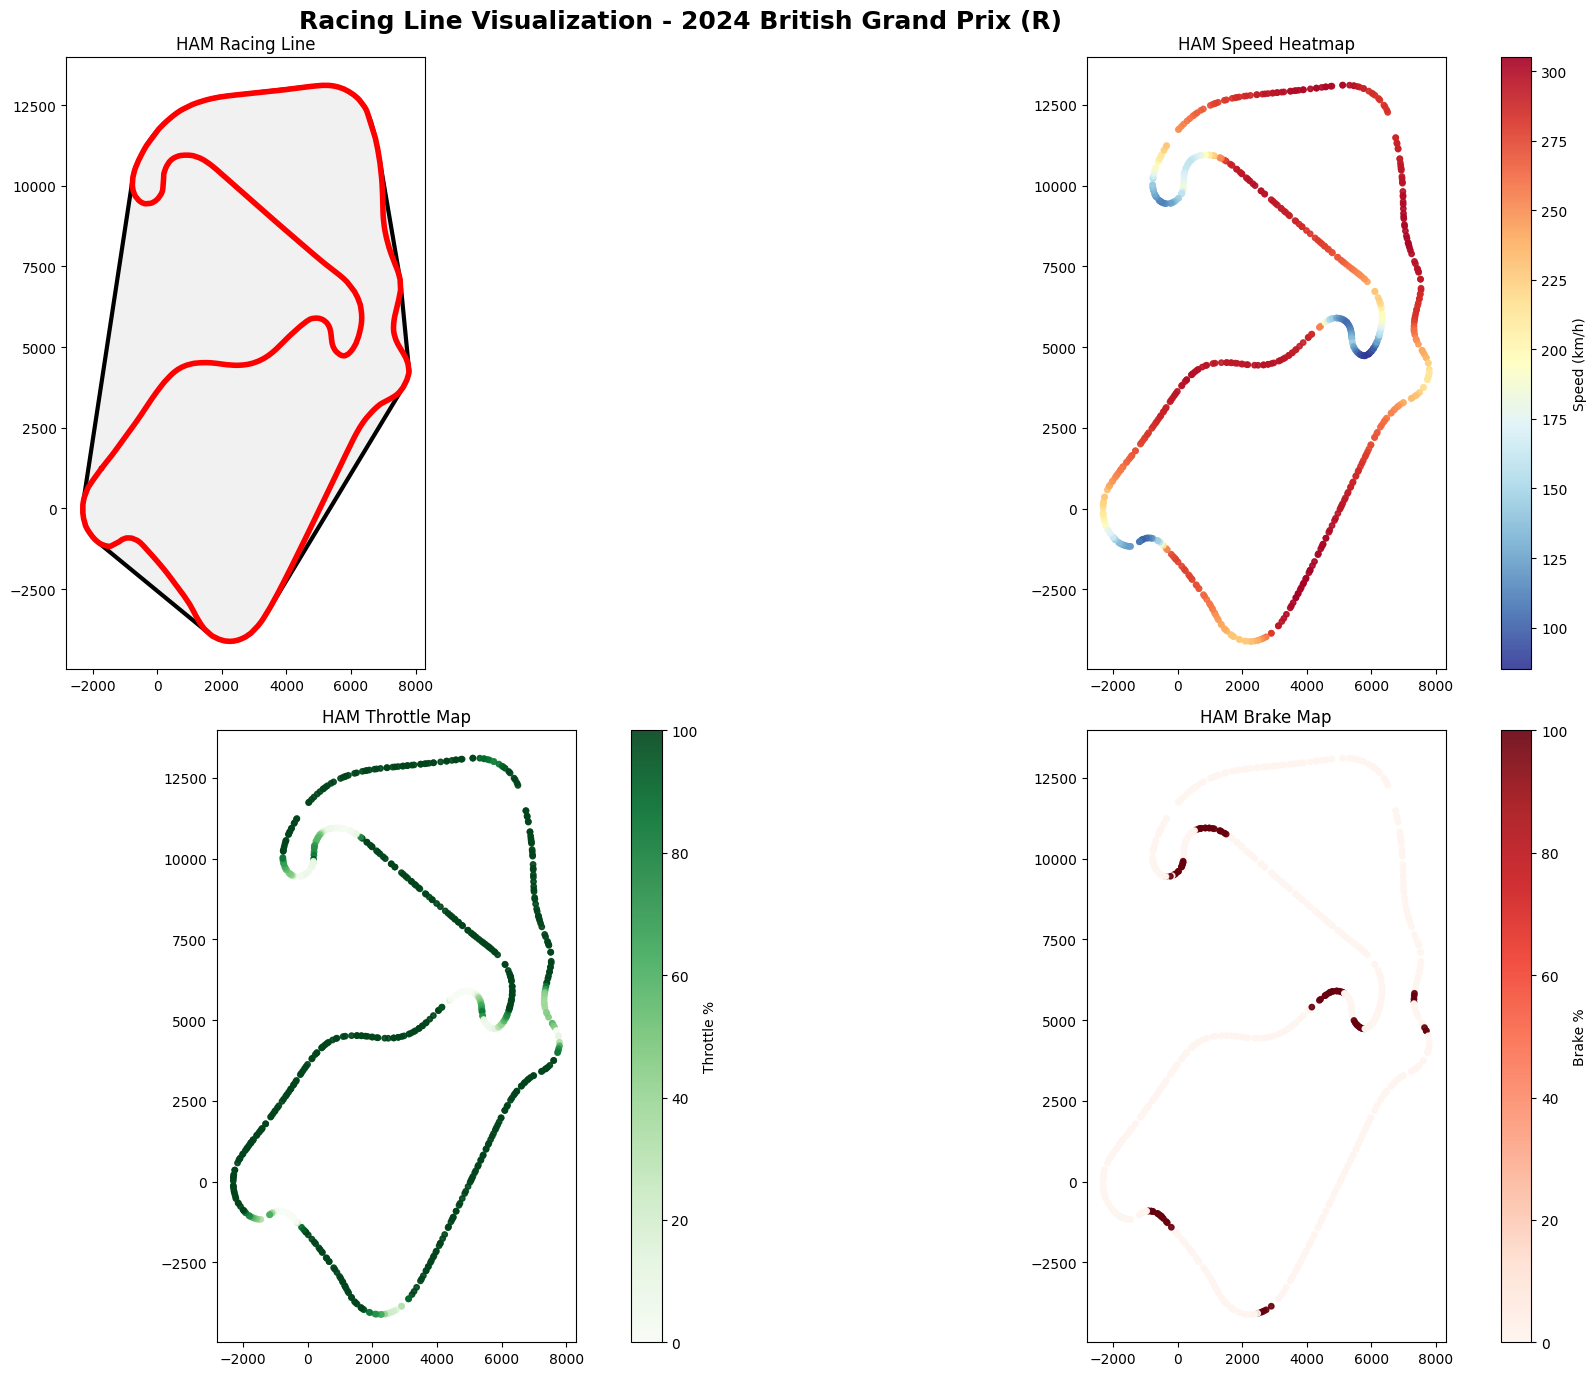

In [12]:
# --- PLOTTING ---
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# 1. Track with racing line
ax = axes[0, 0]
if hull_points is not None:
    ax.plot(np.append(hull_points[:, 0], hull_points[0, 0]),
            np.append(hull_points[:, 1], hull_points[0, 1]),
            'black', linewidth=3)
    ax.fill(np.append(hull_points[:, 0], hull_points[0, 0]),
            np.append(hull_points[:, 1], hull_points[0, 1]),
            color='lightgray', alpha=0.3)
ax.plot(telemetry['X'], telemetry['Y'], 'r', linewidth=4)
ax.set_title(f'{target_driver} Racing Line')
ax.set_aspect('equal')

# 2. Speed heatmap
ax = axes[0, 1]
sc = ax.scatter(telemetry['X'], telemetry['Y'], c=telemetry['Speed'],
                cmap='RdYlBu_r', s=15, alpha=0.9)
plt.colorbar(sc, ax=ax, label='Speed (km/h)')
ax.set_title(f'{target_driver} Speed Heatmap')
ax.set_aspect('equal')

# 3. Throttle
ax = axes[1, 0]
sc = ax.scatter(telemetry['X'], telemetry['Y'], c=telemetry['Throttle'],
                cmap='Greens', s=15, alpha=0.9)
plt.colorbar(sc, ax=ax, label='Throttle %')
ax.set_title(f'{target_driver} Throttle Map')
ax.set_aspect('equal')

# 4. Brake
ax = axes[1, 1]
sc = ax.scatter(telemetry['X'], telemetry['Y'], c=telemetry['Brake'] * 100,
                cmap='Reds', s=15, alpha=0.9)
plt.colorbar(sc, ax=ax, label='Brake %')
ax.set_title(f'{target_driver} Brake Map')
ax.set_aspect('equal')

plt.suptitle(f'Racing Line Visualization - {YEAR} {GRAND_PRIX} ({SESSION_TYPE})',
             fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

core           INFO 	Loading data for British Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

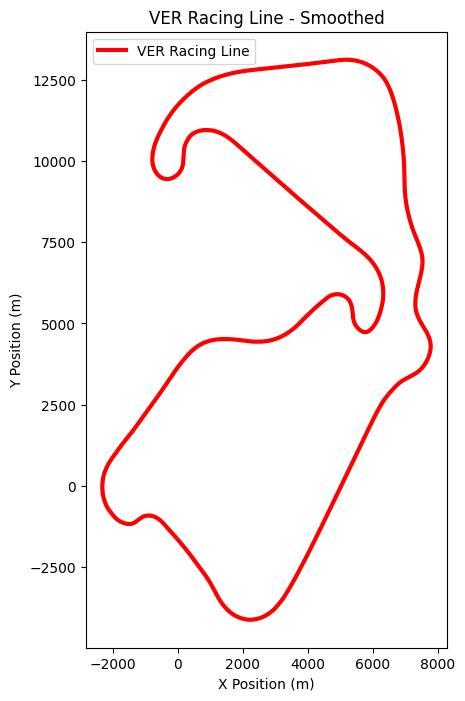

In [15]:
import fastf1
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import numpy as np

# Load session (example: 2024 British GP Race)
session = fastf1.get_session(2024, 'British Grand Prix', 'R')
session.load()

# Select driver (change to whoever you want)
driver = "VER"  # Example: Verstappen

# Get fastest lap
lap = session.laps.pick_driver(driver).pick_fastest()

# Get position data (X,Y)
tel = lap.get_pos_data()

# Function to smooth the line
def smooth_line(x, y, smoothing=2):
    tck, u = splprep([x, y], s=smoothing)
    unew = np.linspace(0, 1, 1000)  # 1000 points for smoothness
    return splev(unew, tck)

# Apply smoothing
x_smooth, y_smooth = smooth_line(tel['X'], tel['Y'])

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x_smooth, y_smooth, color='red', linewidth=3, label=f"{driver} Racing Line")
plt.title(f"{driver} Racing Line - Smoothed")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.gca().set_aspect('equal')
plt.legend()
plt.show()


core           INFO 	Loading data for British Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

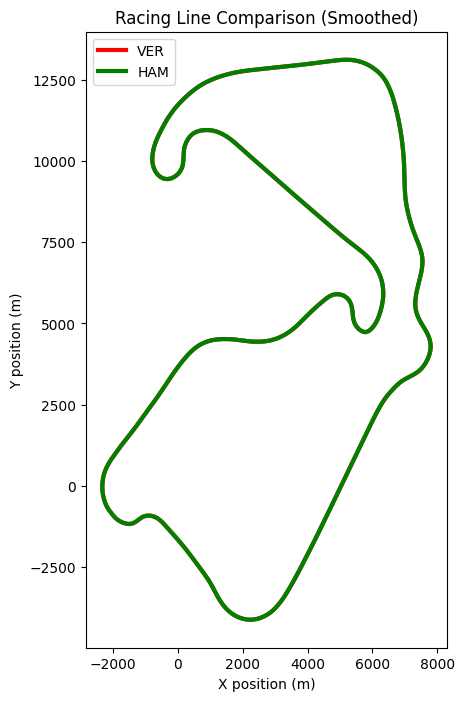

In [17]:
import fastf1
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import numpy as np


session = fastf1.get_session(2024, 'British Grand Prix', 'R')
session.load()

laps = session.laps
drivers = ['VER', 'HAM']  # Example: Verstappen vs Hamilton

def smooth_line(x, y, smoothing=2):
    tck, u = splprep([x, y], s=smoothing)
    unew = np.linspace(0, 1, 500)
    return splev(unew, tck)

plt.figure(figsize=(12, 8))

for drv, color in zip(drivers, ['red', 'green']):
    lap = laps.pick_driver(drv).pick_fastest()
    tel = lap.get_pos_data()
    x_smooth, y_smooth = smooth_line(tel['X'], tel['Y'])
    plt.plot(x_smooth, y_smooth, color=color, linewidth=3, label=drv)

plt.title("Racing Line Comparison (Smoothed)")
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.gca().set_aspect('equal')
plt.legend()
plt.show()


core           INFO 	Loading data for British Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

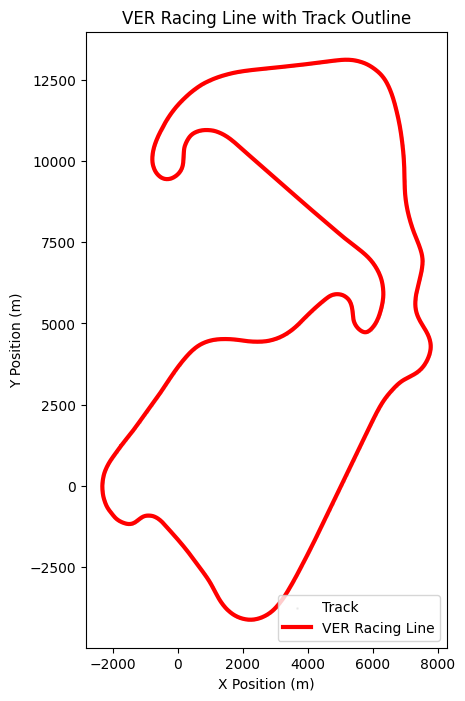

In [18]:
import fastf1
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import numpy as np


# Load session
session = fastf1.get_session(2024, 'British Grand Prix', 'R')
session.load()

# Target driver
driver = "VER"

# Get fastest lap
lap = session.laps.pick_driver(driver).pick_fastest()
tel = lap.get_pos_data()

# === Create track outline (using multiple drivers for boundary) ===
all_x, all_y = [], []
for d in session.drivers[:10]:  # Top 10 drivers
    try:
        dl = session.laps.pick_driver(d).pick_fastest()
        t = dl.get_pos_data()
        all_x.extend(t['X'])
        all_y.extend(t['Y'])
    except:
        continue

# Smooth the driver’s racing line
def smooth_line(x, y, smoothing=2):
    tck, _ = splprep([x, y], s=smoothing)
    unew = np.linspace(0, 1, 2000)
    return splev(unew, tck)

x_s, y_s = smooth_line(tel['X'], tel['Y'])

# Plot
plt.figure(figsize=(12, 8))

# Track outline (light grey “road”)
plt.scatter(all_x, all_y, c='lightgrey', s=1, alpha=0.3, label="Track")

# Driver’s racing line
plt.plot(x_s, y_s, color='red', linewidth=3, label=f"{driver} Racing Line")

plt.title(f"{driver} Racing Line with Track Outline")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()


core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Italian Grand Prix - Qualifying [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for sess

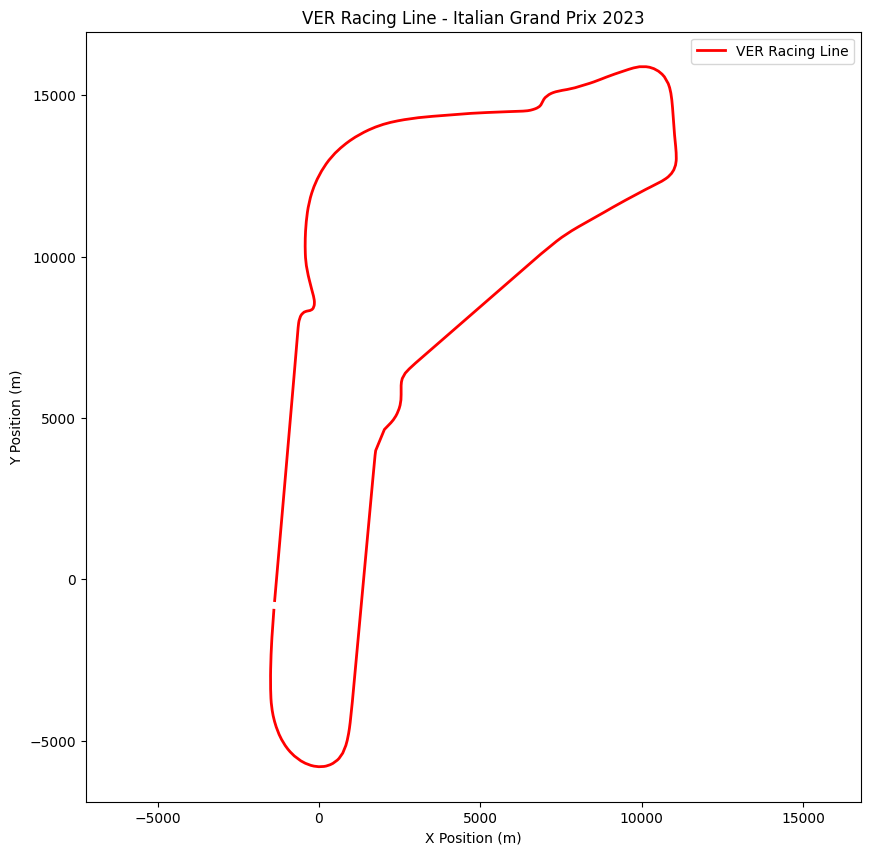

In [19]:
import fastf1.plotting
import matplotlib.pyplot as plt

# Enable fastf1 plotting settings (for track outline, sectors, etc.)
fastf1.plotting.setup_mpl()

# Pick a session
session = fastf1.get_session(2023, "Monza", "Q")
session.load()

# Pick one driver
driver_code = "VER"  # Max Verstappen

# Get that driver's fastest lap
lap = session.laps.pick_driver(driver_code).pick_fastest()

# Get telemetry (with track position data)
tel = lap.get_car_data().add_distance()
pos = lap.get_telemetry()

# Plot track outline with driver racing line
racing_line = lap.get_pos_data()  # positional telemetry (X, Y)

plt.figure(figsize=(10, 10))

# Draw racing line
plt.plot(racing_line['X'], racing_line['Y'], color='red', linewidth=2, label=f"{driver_code} Racing Line")

# Formatting
plt.title(f"{driver_code} Racing Line - {session.event['EventName']} {session.event.year}")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()
plt.axis("equal")  # Keep aspect ratio correct

plt.show()


events      WARNING 	Correcting user input 'British Grad Prix' to 'British Grand Prix'
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Qualifying [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp ''

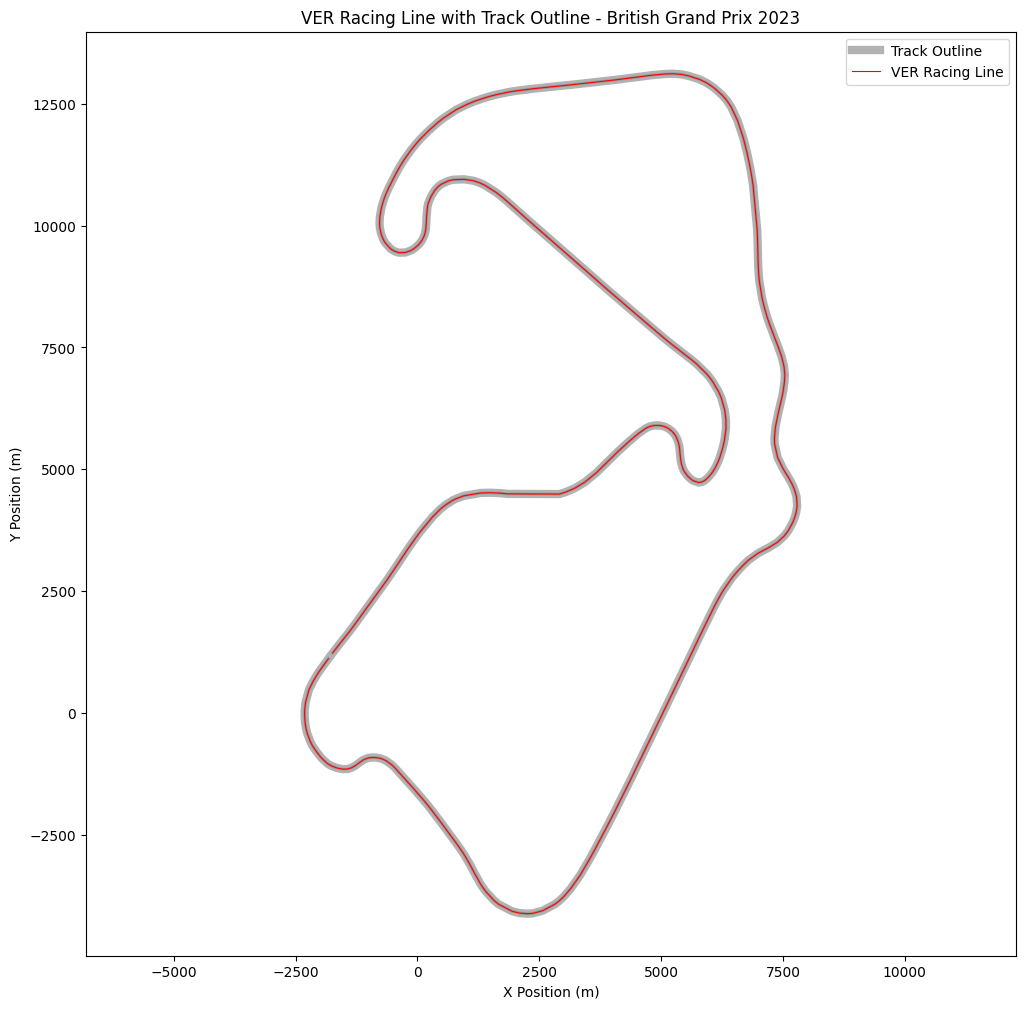

In [21]:
import fastf1
import fastf1.plotting
import matplotlib.pyplot as plt

# Setup FastF1 plotting
fastf1.plotting.setup_mpl()

# Load session
session = fastf1.get_session(2023, "British Grad Prix", "Q")
session.load()

# Select driver
driver_code = "VER"

# Get fastest lap of the driver
lap = session.laps.pick_driver(driver_code).pick_fastest()

# Get positional data (X,Y points around the track)
pos = lap.get_pos_data()

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot track limits (outer boundary)
ax.plot(pos['X'], pos['Y'], color='black', linewidth=6, alpha=0.3, label="Track Outline")

# Plot the actual track line (inner racing track path)
ax.plot(pos['X'], pos['Y'], color='gray', linewidth=2, alpha=0.5)

# Plot driver racing line (thin red line navigating the track)
ax.plot(pos['X'], pos['Y'], color='red', linewidth=0.8, label=f"{driver_code} Racing Line")

# Formatting
ax.set_title(f"{driver_code} Racing Line with Track Outline - {session.event['EventName']} {session.event.year}")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.axis("equal")   # equal scaling so track looks correct
ax.legend()

plt.show()


core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Italian Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

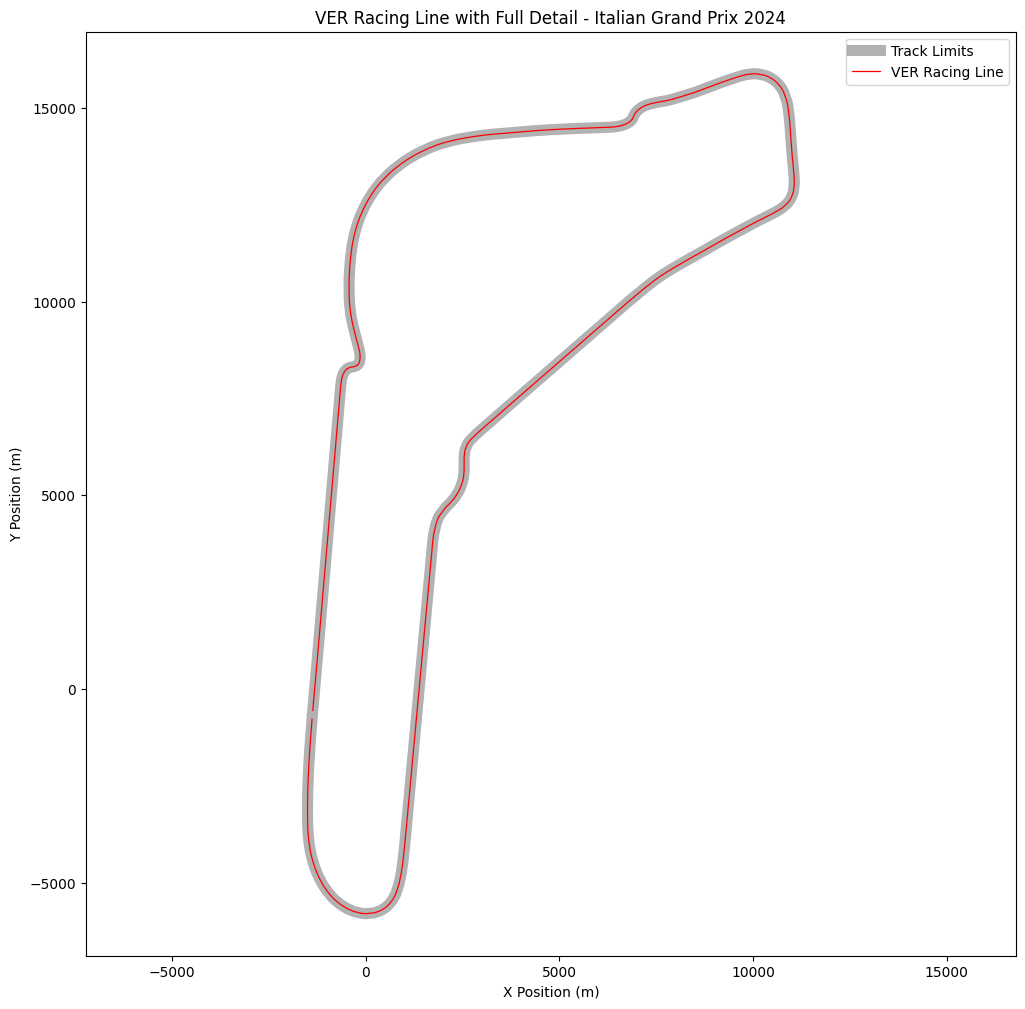

In [23]:
import fastf1
import fastf1.plotting
import matplotlib.pyplot as plt

# Setup matplotlib style for FastF1
fastf1.plotting.setup_mpl()

# Load a session (you can swap year, track, and session type)
session = fastf1.get_session(2024, "Monza", "R")
session.load()

# Pick a driver
driver_code = "VER"
lap = session.laps.pick_driver(driver_code).pick_fastest()

# Get positional (telemetry) data
pos = lap.get_pos_data()

# Plot track + trajectory
fig, ax = plt.subplots(figsize=(12, 12))

# Plot track outline (background "road")
ax.plot(pos['X'], pos['Y'], color='black', linewidth=8, alpha=0.3, label="Track Limits")

# Plot driver’s detailed racing line (thin, showing swerves & curb use)
ax.plot(pos['X'], pos['Y'], color='red', linewidth=0.9, label=f"{driver_code} Racing Line")

# Formatting
ax.set_title(f"{driver_code} Racing Line with Full Detail - {session.event['EventName']} {session.event.year}")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.axis("equal")   # ensures circuit isn't stretched
ax.legend()

plt.show()
